<a href="https://colab.research.google.com/github/maiaufrrj/BRtrading/blob/main/Long_Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! pip install pycaret --upgrade pandas --upgrade

In [1]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pycaret.classification import *
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

In [20]:
filename = '/content/drive/MyDrive/ColabNotebooks/datasets/trading/EURUSD_h1.pkl'
df = pickle.load(open(filename, 'rb'))

def MediaMovelSimples(DF,n):
    ''' função para calcular Média Móvel'''
    df = DF.copy()
    name='MM'+ str(n)  
    df[name] = df['close'].rolling(window=n, min_periods=1).mean()
    df.dropna(inplace=True) 
    return df
    
def DesvioPadrao(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='STD'+ str(n)
    df[name] = df['close'].rolling(window=n, min_periods=1).std()
    df.dropna(inplace=True)  
    return df

def MediaMovelExponcial(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='EWM'+ str(n)
    df[name] = df['close'].ewm(span=n).mean()
    df.dropna(inplace=True) 
    return df


 #ohlcv = pdr.get_data_yahoo(ticker,start,end)
    
def ATR(DF,n):
    '''função para calcular TR e ATR'''    
    df = DF.copy()
    name1='ATR'+ str(n)
    name2='TR' + str(n)
    df['H-L'] = abs(df['high']-df['low'])
    df['H-PC']= abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df[name2]=  df[['H-L','H-PC', 'L-PC']].max(axis=1,skipna=False)
    df[name1]= df[name2].rolling(n).mean()
    df = df.drop(['H-L','H-PC', 'L-PC'],axis=1)
    df.dropna(inplace=True) 
    return df
  
def BollBnd(DF,n):
    '''função para calcular Bandas de Bollinger''' 
    df = DF.copy()
    name1='BBsup'+ str(n)
    name2='BBinf'+ str(n)
    name3='BBlarg'+ str(n)
    df['MA'] = df['close'].rolling(n).mean()
    df[name1] = df['MA'] + 2*df['MA'].rolling(n).std()
    df[name2] = df['MA'] - 2*df['MA'].rolling(n).std()
    df[name3] = df[name1]-df[name2]
    df = df.drop(['MA'],axis=1)
    df.dropna(inplace=True)
    return df

def RSI(DF,n):
    '''função para calcular RSI (Índice de Força Relativa)''' 
    df = DF.copy()
    name='RSI'+ str(n)
    df['delta'] = df['close'] - df['close'].shift(1)
    df['gain'] = np.where(df['delta']>=0,df['delta'],0)
    df['loss'] = np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = [] 
    avg_loss = []
    gain = df['gain'].tolist()
    loss= df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i==n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i>n:
            avg_gain.append(((n-1)*avg_gain[i-1]+gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1]+loss[i])/n)   
    
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS']=df['avg_gain']/df['avg_loss']
    df[name]=100-(100/(1+df['RS']))
    df = df.drop(['delta','avg_gain','avg_loss','loss','gain','RS'],axis=1)
    df.dropna(inplace=True)  
    return df

   
def nIndicadores(DF,n):
    df=DF.copy()
    df = MediaMovelSimples(df,n)
    df = DesvioPadrao(df,n)
    df = MediaMovelExponcial(df,n)
    df = ATR(df,n)
    df = BollBnd(df,n)
    df = RSI(df,n)
    return df

lista=[5,7,9,20,120]
for n in lista:
    df=nIndicadores(df,n)

#del cl_price

'''CRIANDO VARIAVEL DE PREVISÃO (Y) '''

def Forecast(DF,n):
    '''Busca os n preços de fechamento a frente'''
    df = DF.copy()
    df['y']=df['close'].shift(-n)
    df.dropna(inplace=True)
    return df

def movimento_alta(DF,n,percentual_alta):
    '''Verifica se o preço de fechamento n períodos a frente é maior que um certo limite percentual (alta)'''
    df = DF.copy()
    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
    df['alta'] = np.where(df['delta']>=percentual_alta,1,0)
    df = df.drop(['delta'],axis=1)
    df.dropna(inplace=True)  
    return df
    

#def movimento_baixa(DF,n,percentual_baixa):
    '''Verifica se o preço de fechamento n períodos a frente é menor que um certo limite percentual (alta)'''
#    df = DF.copy()
#    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
#    df['baixa'] = np.where(df['delta']<=-percentual_baixa,1,0)
#    df = df.drop(['delta'],axis=1)
#    df.dropna(inplace=True)  
#    return df

#def movimento_baixa(DF, baixa_esperada, periodos_frente):
#    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
#    df = DF.copy()

#    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
#    for i in range(periodos_frente):
#      name='delta'+str(i)
#      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
#
#    for i in range(periodos_frente):
#      df['baixa'] = np.where(df['delta'+str(i)]<=-baixa_esperada,1,0)
    
#    for i in range(periodos_frente):
#      name='delta'+str(i)
#      df = df.drop([name],axis=1)
  
#    df.dropna(inplace=True)
#    return df



#def movimento_baixa(DF, baixa_esperada, periodos_frente):
#    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
#    df = DF.copy()

#    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
#    for i in range(periodos_frente):
#      name='delta_close'+str(i)
#      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
#      name='delta_low'+str(i)
#      df[name] = (df['low'].shift(-i) - df['close'])/df['close']
#      name='delta_high'+str(i)
#      df[name] = (df['high'].shift(-i) - df['close'])/df['close']

#    for i in range(periodos_frente):
#      df['baixa'] = np.where((df['delta_close'+str(i)]<=-baixa_esperada) | (df['delta_low'+str(i)]<=-baixa_esperada) | (df['delta_high'+str(i)]<=-baixa_esperada), 1, 0)
    
#    for i in range(periodos_frente):
#      name1='delta_close'+str(i)
#      name2='delta_low'+str(i)
#      name3='delta_high'+str(i)
#      df = df.drop([name1,name2,name3],axis=1)

#    df.dropna(inplace=True)
#    return df


def movimento_baixa(DF, baixa_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()
    df['baixa'] = 0
    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(1,periodos_frente+1):
      name='delta_close'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']

    for i in range(1,periodos_frente+1):
      df['baixa'+str(i)] = np.where(df['delta_close'+str(i)]<=-baixa_esperada,1,0)
    
    for i in range(1,periodos_frente+1):
      df['baixa'] = df['baixa'] + df['baixa'+str(i)]

    #trocando sinais aqui!!!
    df['baixa'] = np.where(df['baixa']>=1,0,1)

    for i in range(1,periodos_frente+1):
      name1='delta_close'+str(i)
      name2='baixa'+str(i)
      df = df.drop([name1,name2],axis=1)
      
    df.dropna(inplace=True)
    return df


def look_forward(DF, alta_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()
    df['look_forward'] = 0

    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(1,periodos_frente+1):
      name='delta_close'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']
      #name='delta_low'+str(i)
      #df[name] = (df['low'].shift(-i) - df['close'])/df['close']
      #name='delta_high'+str(i)
      #df[name] = (df['high'].shift(-i) - df['close'])/df['close']

    for i in range(1,periodos_frente+1):
      #df['look_forward'] = np.where((df['delta_close'+str(i)]>=alta_esperada) | (df['delta_low'+str(i)]>=alta_esperada) | (df['delta_high'+str(i)]>=alta_esperada), 1, 0)
      df['look_forward'+str(i)] = np.where(df['delta_close'+str(i)]>=alta_esperada,1,0)

    for i in range(1,periodos_frente+1):
      df['look_forward'] = df['look_forward'] + df['look_forward'+str(i)]
    
    df['look_forward'] = np.where(df['look_forward']>=1,1,0)

    for i in range(1,periodos_frente+1):
      name1='delta_close'+str(i)
      name2='look_forward'+str(i)
      df = df.drop([name1,name2],axis=1)

    df.dropna(inplace=True)
    return df


#definindo intervalo de previsão. n=1 >> previsão do período posterior
#df = Forecast(df,2)


baixa_esperada = 0.004
df = movimento_baixa(df,baixa_esperada,6)

percentual_alta = 0.004
alta_esperada = 0.004
df = look_forward(df,alta_esperada,6) #target



#df = movimento_alta(df,5,percentual_alta) #target

#print(f'altas: {df.alta.sum()}, baixas:{df.baixa.sum()}')

#definindo o target = df['look_forward']
df['y']=df['look_forward']
del df['look_forward']


In [ ]:
df.head(20)

In [ ]:
workbook='/content/drive/MyDrive/ColabNotebooks/datasets/trading/dataframe_eurusd.xlsx'
df.to_excel(workbook)

In [22]:
#def rename_target(DF,target):
#  df = DF.copy()
#  for i in range(df.columns):
#    df['y'] = df[target] 
#  if (df.columns[-1] == 'alta') | (df.columns[-1] == 'baixa'):
#    df = DF.copy()

#intialize the setup
separar=720 #separando 720hs de dataset (1 mês)
df_validacao = df.iloc[-separar:,:]

df_train = df.iloc[:-(separar-1),:]

X= df_train.iloc[:,:-1]  #da primeira à penultima (variáveis dependentes)
y= df_train.iloc[:,-1]    #ultima coluna (dados de previsão)

In [23]:
#balanceamento SMOTE
exp_clf = setup(df_train,
                target = 'y', 
                fold_strategy = 'timeseries',
                fold = 10,
                train_size=0.7,
                feature_selection = True,
                fix_imbalance = True,
                #feature_selection_threshold = 0.70,  '''para long_target '''
                feature_selection_threshold = 0.70,
                remove_multicollinearity = True,
                #multicollinearity_threshold = 0.80,
                remove_perfect_collinearity = True,
                normalize = True,
                n_jobs=-1,
                session_id = 123)

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8642, 54)"
5,Missing Values,False
6,Numeric Features,52
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
best = compare_models(sort = 'MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9632,0.8355,0.3357,0.5182,0.3961,0.3787,0.3938,0.814
lightgbm,Light Gradient Boosting Machine,0.9417,0.7920,0.3975,0.2833,0.3243,0.2952,0.3031,0.390
rf,Random Forest Classifier,0.9501,0.8194,0.3137,0.3232,0.3119,0.2867,0.2898,2.054
gbc,Gradient Boosting Classifier,0.8532,0.7579,0.4711,0.1219,0.1881,0.1389,0.1802,2.887
dt,Decision Tree Classifier,0.8834,0.6258,0.3476,0.1246,0.1817,0.1351,0.1560,0.171
ada,Ada Boost Classifier,0.7995,0.7021,0.5112,0.0919,0.1520,0.0968,0.1464,0.709
ridge,Ridge Classifier,0.7104,0.0000,0.5536,0.0694,0.1225,0.0614,0.1103,0.033
lda,Linear Discriminant Analysis,0.7100,0.7005,0.5536,0.0693,0.1224,0.0612,0.1101,0.049
lr,Logistic Regression,0.7151,0.6892,0.5258,0.0674,0.1183,0.0573,0.1020,0.599
nb,Naive Bayes,0.2967,0.6849,0.8710,0.0445,0.0843,0.0154,0.0626,0.035


In [25]:
#criando modelos
model = create_model(best)
model_tuned = tune_model(estimator = model,  fold = 15,  round = 4,  n_iter = 100,  optimize = 'MCC', verbose = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9206,0.7627,0.3333,0.1111,0.1667,0.1358,0.1588
1,0.9074,0.7273,0.4167,0.3226,0.3636,0.3146,0.3176
2,0.9048,0.8206,0.3750,0.0882,0.1429,0.1124,0.1465
3,0.9286,0.7329,0.3571,0.2174,0.2703,0.2350,0.2431
4,0.8810,0.7587,0.1538,0.0556,0.0816,0.0328,0.0377
5,0.8942,0.8281,0.6667,0.1818,0.2857,0.2482,0.3107
6,0.8889,0.8304,0.5556,0.2273,0.3226,0.2735,0.3062
7,0.9074,0.8001,0.5833,0.1892,0.2857,0.2497,0.2958
8,0.8915,0.8030,0.5385,0.1667,0.2545,0.2132,0.2566
9,0.8836,0.7977,0.4286,0.1429,0.2143,0.1681,0.1981


In [26]:
evaluate_model(model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [27]:
#finalize a model
final_model = finalize_model(model_tuned)
save_model(final_model, '/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/long_target_et')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='y',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight={}, criterion='gini',
                                       max_depth=11, max_features=1.0,
                                       max_leaf_nodes=None,

In [ ]:
#salvando modelo
#import pickle
#filename = '/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/et_tuned01.pkl'
#pickle.dump(final_model, open(filename, 'wb'))

In [28]:
# generate predictions on the original dataset
predictions_df = predict_model(final_model, data=df_train)
predictions_df = predictions_df.reset_index()

def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    #df['look_forward'] = np.where(df['baixa']==1,df['close'],0)
    return df

predictions_df = alinhar_pontos(predictions_df)

In [30]:
# line plot
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df, x='time', y='close', template = 'plotly_dark')

#fig = go.Figure(data=[go.Candlestick(x=predictions_df['time'],
#                open=predictions_df['open'],
#                high=predictions_df['high'],
#                low=predictions_df['low'],
#                close=predictions_df['close'])])

fig.add_scatter(x=predictions_df['time'], y=predictions_df['Label'], mode='markers', marker_color='rgba(0, 255, 0, .8)')
#fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df.close.min()
ymax=predictions_df.close.max()
fig.update_yaxes(range=[ymin, ymax])
fig.show()
fig.write_html('/content/drive/MyDrive/ColabNotebooks/datasets/trading/modelos/long_target_et.html')

In [ ]:
#! pip install backtrader

In [ ]:
# testando dados no dataset de validação
predictions_df_teste = predict_model(model_tuned, data=df_validacao)
predictions_df_teste = predictions_df_teste.reset_index()

8

In [ ]:
def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    #df = df.drop(['delta'],axis=1)
    #df.dropna(inplace=True)  
    return df

predictions_df_teste = alinhar_pontos(predictions_df_teste)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df_teste, x='time', y='close', template = 'plotly_dark')
fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['Label'], mode='markers', marker_color='rgba(255, 0, 0, .8)')
#fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df_teste.close.min()
ymax=predictions_df_teste.close.max()
fig.update_yaxes(range=[ymin, ymax])

fig.show()
fig.write_html("short_target_valid_mcc.html")

In [ ]:
#!pip install bta-lib
#!pip install bt
import btalib as bta

In [ ]:
predictions_df_teste.head()

In [ ]:
close = pd.DataFrame()
close['sinal'] = np.where(predictions_df_teste['look_forward']>=1,1,0)
close['sinal'] = pd.to_numeric(close['sinal'])
close.set_index(predictions_df_teste.time, inplace=True)
close.fillna(0)
#close.value_counts()

venda = pd.DataFrame()
venda['sinal'] =np.where(predictions_df_teste['Label']!=0,-1,0)
venda['sinal'] = pd.to_numeric(venda['sinal'])
venda.fillna(0)
#venda.value_counts()

posicao = venda.copy()
posicao['sinal'] = 0
posicao[close.values == 1] = 1.0
posicao[venda.values == -1] = -1.0
posicao.set_index(predictions_df_teste.time, inplace=True)
posicao['sinal'].fillna(0)
posicao.value_counts()

sinal
 0       691
-1        28
 1         1
dtype: int64

In [ ]:
close = pd.DataFrame()
close['sinal'] = predictions_df_teste['close']
close.set_index(predictions_df_teste.time, inplace=True)

#3. Criar estrutura de backtesting

In [ ]:
#https://pmorissette.github.io/bt/
#https://colab.research.google.com/drive/1K56P-z6RK01tLYSvfRVadxQGKUp7h7VO?usp=sharing#scrollTo=EepGT0mwt6ou

In [ ]:
# download data
# calculate moving average DataFrame using pandas' rolling_mean
# a rolling mean is a moving average, right?
#sma = df_train.close.rolling(5).mean()

In [ ]:
import bt
et_strategy = bt.Strategy('et_strategy', [bt.algos.WeighTarget(posicao),
                                bt.algos.Rebalance()])

et_teste = bt.Backtest(et_strategy, close)
resultado = bt.run(et_teste)
#resultado.display()
#resultado.plot()
#resultado.plot_weights('et_strategy')

In [ ]:
s1 = bt.Strategy('s1', [bt.algos.SelectAll(),
                        bt.algos.WeighTarget(posicao),
                        bt.algos.Rebalance()])

s1_teste = bt.Backtest(s1, close, initial_capital=1000)
#, commissions=0.1)
                 #integer_positions=integer_positions)

res = bt.run(s1_teste)
#res.display()
#res.plot()
#res.plot_weights('s1')

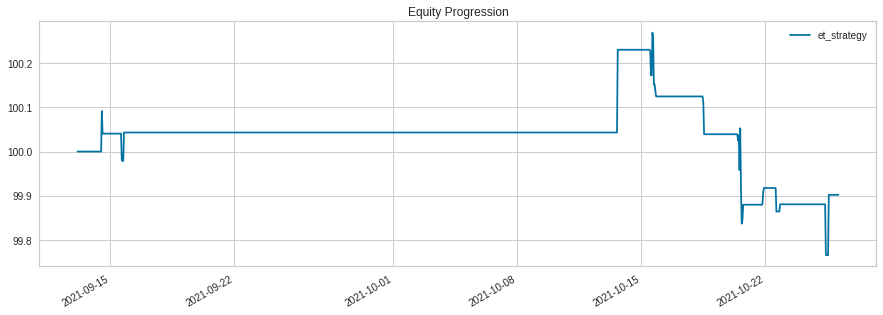

In [ ]:
resultado.plot()

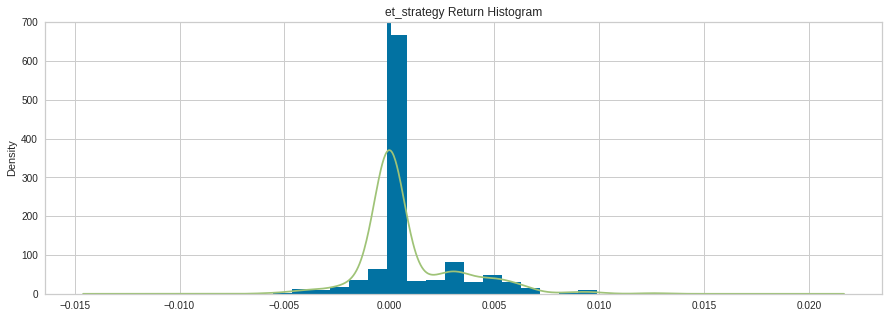

In [ ]:
resultado.plot_histogram()

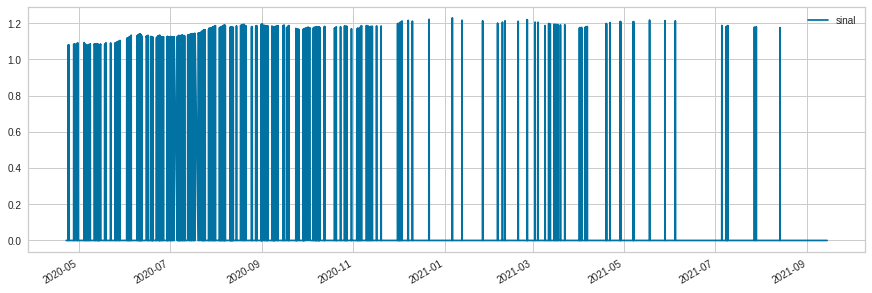

In [ ]:
resultado.plot_security_weights()

In [ ]:
# create our new strategy
s2 = bt.Strategy('s2', [bt.algos.RunDaily(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])

# now let's test it with the same data set. We will also compare it with our first backtest.
s2_teste = bt.Backtest(s2, close)
# we include test here to see the results side-by-side
resultado2 = bt.run(s1_teste, s2_teste)
#resultado2.display()

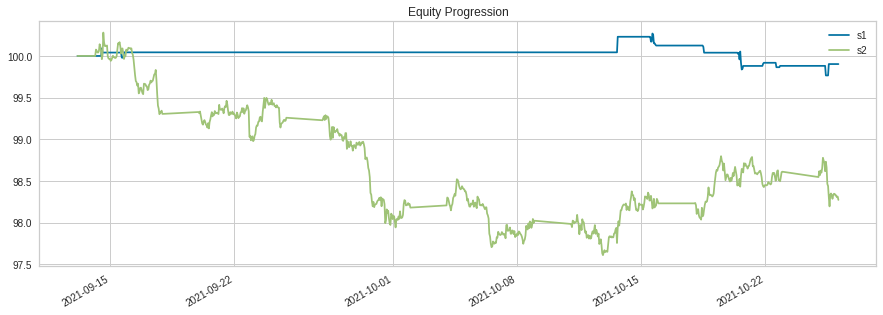

In [ ]:
resultado2.plot()

In [ ]:

btc_close = pd.DataFrame()
btc_close['sinal'] = predictions_df_teste['close']

btc_close.set_index(predictions_df_teste['time'], inplace=True)
btc_bands = bta.bbands(btc_close, period=20, devs=2.0).df
btc_up = pd.DataFrame()
btc_down = pd.DataFrame()

btc_down['sinal'] = btc_bands['bot']
btc_up['sinal'] =btc_bands['top']
btc_down['sinal'] = pd.to_numeric(btc_down['sinal'])
btc_up['sinal'] = pd.to_numeric(btc_up['sinal'])

btc_down.fillna(0)
btc_up.fillna(0)

posicao2 = btc_up.copy()
posicao2['sinal'] = 0

posicao2[btc_close > btc_up] = -1.0
posicao2[btc_close <= btc_down] = 1.0
posicao2['sinal'].fillna(0)

bbands = bt.Strategy('bbands', [bt.algos.WeighTarget(posicao2),
                                bt.algos.Rebalance()])

bteste = bt.Backtest(bbands, btc_close)

resultado2 = bt.run(bteste)
#resultado2.display()
#resultado2.plot()
#resultado2.plot_weights('bbands')

mm50 = pd.DataFrame()
mmm200 = pd.DataFrame()
mm50 = bta.sma(btc_close.sinal, period=50).df
mm200 = bta.sma(btc_close.sinal, period=200).df
mm50['sinal'] = mm50
mm200['sinal'] =mm200
posicao_2 = btc_up.copy()
posicao_2['sinal'] =0
posicao_2[mm50 > mm200] = 1.0
posicao_2[mm50 <=mm200] = -1.0
posicao_2.fillna(0)
mmovel = bt.Strategy('mmovel', [bt.algos.WeighTarget(posicao_2),
                                bt.algos.Rebalance()])

teste_sma = bt.Backtest(mmovel, btc_close)

benchmark = bt.Strategy('benchmark', [bt.algos.RunYearly(),
                                      bt.algos.SelectAll(),
                                      bt.algos.WeighEqually(),
                                      bt.algos.Rebalance()])

benchmark_teste = bt.Backtest(benchmark, btc_close)
b_resultado = bt.run(et_teste, bteste, teste_sma, benchmark_teste)
b_resultado.display()

Stat                 et_strategy    bbands      mmovel      benchmark
-------------------  -------------  ----------  ----------  -----------
Start                2021-09-13     2021-09-13  2021-09-13  2021-09-13
End                  2021-10-26     2021-10-26  2021-10-26  2021-10-26
Risk-free rate       0.00%          0.00%       0.00%       0.00%

Total Return         -0.10%         -0.14%      1.36%       -1.73%
Daily Sharpe         -0.95          -0.47       3.10        -3.39
Daily Sortino        -1.36          -0.58       5.52        -5.12
CAGR                 -0.83%         -1.15%      12.17%      -13.77%
Max Drawdown         -0.35%         -0.84%      -0.57%      -2.42%
Calmar Ratio         -2.37          -1.37       21.37       -5.70

MTD                  -0.14%         -0.01%      -0.01%      0.23%
3m                   -              -           -           -
6m                   -              -           -           -
YTD                  -0.10%         -0.14%      1.36%     

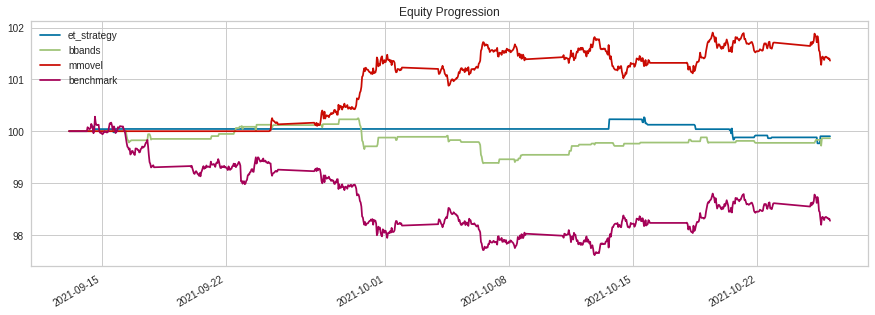

In [ ]:
b_resultado.plot()

In [ ]:
#finalize a model
final_model = finalize_model(model_tuned)

In [ ]:
df_result = pd.DataFrame(b_resultado)

ValueError: ignored

In [ ]:
model_tuned

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)